# BERT TRAINING

# Install all need

In [1]:
!pip install tensorflow_hub
!pip install bert-tensorflow

  Using cached https://files.pythonhosted.org/packages/ac/64/3bba86ca49ef21a4add11a4d37e3f6cd05d2e61d207ebe26a8a96b340826/tensorflow_hub-0.6.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a6/66/7eb4e8b6ea35b7cc54c322c816f976167a43019750279a8473d355800a93/bert_tensorflow-1.0.1-py2.py3-none-any.whl


# Google Colab 設定(如果非Colab可跳過)

In [2]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p Drive
!google-drive-ocamlfuse Drive

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.go

In [3]:
#查看當前位置
!pwd

/content


In [4]:
%cd Drive
!pwd

/content/Drive
/content/Drive


In [5]:
!ls

 20180413校園宿舍門鎖查看.zip   frcnn.zip
 20181006		        IMG_0678.MOV
 2018825_AI_ricky演講	        IMG_0679.MOV
 AK.zip			        Market-1501-v15.09.15.rar
 audio			       'office 2010.rar'
 cam1			        opencv_kerasyolov3.zip
 cam1_cut		       'People counting'
 cam2			       'python基礎語法 .ipynb'
 cam2_cut		       'python基礎語法(經理班).ipynb 的副本'
 car_detection_Hao.rar	        soccer.mp4
 cia_frcnn-master.rar	       'THU-Mayu research'
'Colab Notebooks'	        人員計數20181009.pptx
 cuhk03_release.rar	        經理人講義
 DukeMTMC-reID.zip	        艾創
 DukeMTMC-VideoReID.zip         跨鏡頭人員追蹤進度
 final_presentation.mp4


In [ ]:
# 指定当前的工作文件夹
import os

# 此處為google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("/content/Drive/Colab Notebooks") 

In [7]:
#再次查看
!ls

 bert_cnn.ipynb  '“python基礎語法(經理班).ipynb”的副本'   week
 data_food.csv	  vocab.txt


# Import library

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from datetime import datetime
from matplotlib import pyplot as plt 
%matplotlib inline

In [3]:
#讀檔
df = pd.read_csv('data_food.csv')

In [4]:
#查看前五筆
df.head()

,comment,sentiment
0,口味：不知道是我口高了，还是这家真不怎么样。 我感觉口味确实很一般很一般。上菜相当快，我敢说...,0
1,菜品丰富质量好，服务也不错！很喜欢！,1
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,0
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,1
4,先说我算是娜娜家风荷园开业就一直在这里吃 每次出去回来总想吃一回 有时觉得外面的西式简餐总是...,1


# Import Bert

In [5]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

W0925 14:18:13.236938 140418891273984 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# 做tokenizer

In [6]:
def create_tokenizer(vocab_file, do_lower_case=False):
    return tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)
    
tokenizer = create_tokenizer('vocab.txt', do_lower_case=False)

W0925 14:18:14.376213 140418891273984 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [7]:
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens) #將中文轉換ids
    input_mask = [1] * len(input_ids)

    #Zero Mask till seq_length
    zero_mask = [0] * (max_seq_len-len(tokens))
    input_ids.extend(zero_mask)
    input_mask.extend(zero_mask)
    segment_ids.extend(zero_mask)
    
    return input_ids, input_mask, segment_ids

def convert_sentences_to_features(sentences, tokenizer, max_seq_len=200):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    
    for sentence in sentences:
        input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
        all_input_ids.append(input_ids)
        all_input_mask.append(input_mask)
        all_segment_ids.append(segment_ids)
    
    return all_input_ids, all_input_mask, all_segment_ids

# 開始訓練Bert

In [8]:
#定義Module
bert_module = 'https://tfhub.dev/google/bert_chinese_L-12_H-768_A-12/1'
module = hub.Module(bert_module)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

input_ids = tf.placeholder(dtype=tf.int32, shape=[None, None])
input_mask = tf.placeholder(dtype=tf.int32, shape=[None, None])
segment_ids = tf.placeholder(dtype=tf.int32, shape=[None, None])

bert_inputs = dict(
    input_ids=input_ids,
    input_mask=input_mask,
    segment_ids=segment_ids)

bert_outputs = module(bert_inputs, signature="tokens", as_dict=True)

In [11]:
#開始訓練
#%%time
#全部比數轉vect
#sentences = df.comment[:]
sentences ='菜品丰富质量好，服务也不错！很喜欢！'
input_ids_vals, input_mask_vals, segment_ids_vals = convert_sentences_to_features(sentences, tokenizer, 200)

out = sess.run(bert_outputs, feed_dict={input_ids: input_ids_vals, input_mask: input_mask_vals, segment_ids: segment_ids_vals})
out = out['sequence_output']

In [8]:
out.shape

NameError: name 'out' is not defined

# 存取Numpy檔與讀取

In [ ]:
#存取
np.save('bert_vector_array', out)

In [9]:
#讀取已經訓練好的npy檔
out = np.load('bert_vector_array.npy')

In [10]:
#查看shape
out.shape

(2000, 200, 768)

In [12]:
out[0].shape

(200, 768)

# 切分資料將前1600筆分為train資料後400筆則為test資料

In [8]:
#切分資料
X_train  = np.array(out[:1600])
y_train = np.array(df.sentiment[:1600])

X_test = np.array(out[1600:])
y_test = np.array(df.sentiment[1600:])

In [9]:
#查看shape
X_train.shape

(1600, 200, 768)

In [10]:
#查看第0筆資料
X_train[0]

array([[ 0.1637654 ,  0.8360576 , -1.3566983 , ..., -0.51227415,
         0.27192864, -0.22377066],
       [ 0.7705964 , -0.03429148, -0.36578628, ..., -0.1575123 ,
        -0.39307886,  0.5341522 ],
       [ 1.7171843 , -0.8632288 , -1.1028628 , ...,  1.21928   ,
         0.3121938 , -0.0767564 ],
       ...,
       [-0.6006625 , -0.56261635,  0.5839042 , ..., -0.5153134 ,
         0.7820772 , -0.03130491],
       [-0.6057044 , -0.50051975,  0.883203  , ...,  0.437612  ,
         0.15986411,  0.23221825],
       [-0.15585825,  0.84555066, -0.73063844, ..., -0.06108847,
         0.6871545 , -0.02797217]], dtype=float32)

In [11]:
y_train

array([0, 1, 0, ..., 1, 1, 1])

In [12]:
X_test.shape

(400, 200, 768)

In [25]:
X_test[0].shape

(200, 768)

In [13]:
y_test

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,

# 進行Model訓練(CNN1D)

In [27]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D,Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding,Flatten
from keras.models import Model,Sequential
from keras.initializers import Constant

#建立Sequential Model
model = Sequential()
model.add(Conv1D(nb_filter=64, kernel_size=5,activation='relu', input_shape=(200, 768)))
model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2, padding='valid'))
#model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
#model.add(Dense(1, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, activation="relu", input_shape=(200, 768), filters=64)`
  


In [28]:
#查看模型摘要
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 196, 64)           245824    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 194, 8)            1544      
_________________________________________________________________
dropout_9 (Dropout)          (None, 194, 8)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 97, 8)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 97, 8)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 776)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               77700     
__________

In [18]:
#開始訓練並設置EarlyStopping
import keras
from keras.callbacks import EarlyStopping 

early_stopping = keras.callbacks.EarlyStopping(
     monitor='val_loss', 
     patience=10, #没有进步的训练轮数，在这之后训练就会被停止
     min_delta=0.1, #小於 min_delta 的绝对变化会被认为没有提升。
     verbose=1, 
     mode='auto'
)

# modelcnn1d.fit(X, y, validation_split=0.2, callbacks=[early_stopping])

history = model.fit(X_train, y_train,epochs=20,batch_size=16,shuffle=False,callbacks=[early_stopping],validation_data=(X_test, y_test))


model.save('bert_1.h5')

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 3s 2ms/step - loss: 0.7146 - acc: 0.5356 - val_loss: 0.6376 - val_acc: 0.6050
Epoch 2/20
1600/1600 [==============================] - 1s 523us/step - loss: 0.6198 - acc: 0.7256 - val_loss: 0.7328 - val_acc: 0.6675
Epoch 3/20
1600/1600 [==============================] - 1s 543us/step - loss: 0.5642 - acc: 0.7625 - val_loss: 0.5471 - val_acc: 0.8075
Epoch 4/20
1600/1600 [==============================] - 1s 535us/step - loss: 0.5538 - acc: 0.7525 - val_loss: 0.5898 - val_acc: 0.7600
Epoch 5/20
1600/1600 [==============================] - 1s 586us/step - loss: 0.5195 - acc: 0.8063 - val_loss: 0.4989 - val_acc: 0.8175
Epoch 6/20
1600/1600 [==============================] - 1s 584us/step - loss: 0.5083 - acc: 0.8000 - val_loss: 0.5849 - val_acc: 0.7550
Epoch 7/20
1600/1600 [==============================] - 1s 544us/step - loss: 0.4717 - acc: 0.8106 - val_loss: 0.4203 - val_acc: 0.8275
Epo

In [19]:
df.head()

,comment,sentiment
0,口味：不知道是我口高了，还是这家真不怎么样。 我感觉口味确实很一般很一般。上菜相当快，我敢说...,0
1,菜品丰富质量好，服务也不错！很喜欢！,1
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,0
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,1
4,先说我算是娜娜家风荷园开业就一直在这里吃 每次出去回来总想吃一回 有时觉得外面的西式简餐总是...,1


In [32]:
X_test.shape

(400, 200, 768)

In [31]:
X_test[0]

array([[ 1.4443636e+00,  3.9928621e-01, -8.3959758e-01, ...,
         9.3205079e-02,  6.5041608e-01, -6.1584778e-02],
       [ 3.8644505e-01,  8.6537474e-01,  3.5419178e-01, ...,
        -6.8555319e-01,  2.0825309e-01,  1.8483304e-03],
       [ 1.2055862e+00,  4.5651135e-01, -1.5036626e+00, ...,
        -3.1491888e-01,  2.4682826e-01, -6.6685736e-01],
       ...,
       [ 4.0447038e-01,  1.1171593e-01, -1.1001744e+00, ...,
         9.9001482e-02,  1.2209472e-01, -6.6680050e-01],
       [ 4.2137635e-01, -1.3816568e-01, -8.4432149e-01, ...,
        -6.8733513e-02, -4.9334764e-04, -4.8911488e-01],
       [ 4.2768332e-01, -2.9152170e-01, -1.1072432e+00, ...,
        -1.0998309e-01,  1.8507503e-02, -5.0481673e-02]], dtype=float32)

In [39]:
X_test.shape

(400, 200, 768)

In [41]:
X_test[0].shape

(200, 768)

In [34]:
a = model.predict(X_test)

In [36]:
a[0]

array([0.11180234], dtype=float32)

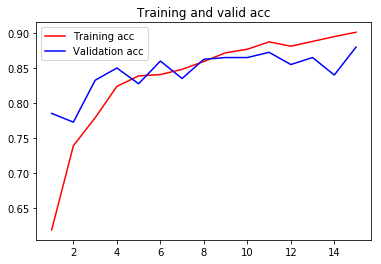

In [ ]:
#將ACC畫出
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and valid acc')
plt.legend()
plt.savefig('acc.png')

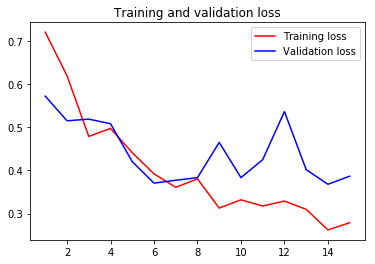

In [ ]:
#畫出Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()